#  Optimal Decisions for Discrete Stochastic Systems

We are ready to tackle our third example from this chapter's introduction: 

```{panels}
Example: Binary Communication System
^^^
In a binary communication system, 0s and 1s are transmitted over a noisy channel.

If we know the probability that a given bit is a 0 and we know the probabilities associated with the noisy channel, what is the optimal decision given an observation at the output of the channel?
```

Let's start by considering one particular instantiation of this problem: 

## Binary Communication System

Suppose we are given a system with that has binary inputs and ternary outputs. Let's use $A_0$ and $A_1$ to denote the input events and $B_0$, $B_1$, and $B_2$ to denote the output events. The channel is completely specified by giving the likelihoods, $P(B_j|A_i)$ for all $i \in \{0,1\}$ and $j \in \{0,1,2\}. 

Let $p_{ij} = P(B_j|A_i)$. Note the order of the $i$ and $j$.  This is the probability of transitioning from input $i$ to output $j$, and these are also called *channel transition probabilities*. It is helpful to visualize the channel transition probabilities/likelihoods on a diagram, where we label the arrow connecting input event $A_i$ with output event $B_j$ by $p_{ij}$. An  example of such a diagram is shown in {numref}`example2to3`. For example, from this diagram, we can read that $p_{00}=5/8$, $p_{01}=1/4$, and $p_{12}=3/4$.

:::{figure-md} example2to3

<img src="example2to3.svg" alt="Channel diagram with two inputs ($A_0, A_1$) and three outputs ($B_0, B_1, B_2$). Probabilities are shown for each transition." width="400px">

Example channel transition diagram for channel with two inputs and three outputs.
:::


It is convenient to collect the channel transition probabilities into an array, such that the $(i,j)$th entry in the array is $p_{ij}$. Let's import numpy and create an array with these channel transition probabilities:

In [1]:
import numpy as np

P=np.array([
    [5/8, 1/4, 1/8],
    [1/8, 1/8, 3/4]
])

print(P)

[[0.625 0.25  0.125]
 [0.125 0.125 0.75 ]]


Note that the probabilities with the same conditioning should add to 1. In other words,

$$
\sum_{j \in \{0,1,2\} }  P(B_j|A_i) = 1, ~~~ i=0,1.
$$
In the diagram, this corresponds to the transition probabilities that emerge from the same input. In the matrix $\mathbf{P},$ this corresponds to all of the entries in a row. We can tell numpy to sum the array across the column by using the `np.sum` function and passing the `axis=1` argument to tell it to sum across the second axis (the columns):

In [2]:
np.sum(P, axis=1)

array([1., 1.])

Note that the probabilities for a particular $B_j$ (i.e., merging into a particular output) do not necessarily sum to 1.


$$
\sum_{i \in \{0,1\} }  P(B_j|A_i) = ?, ~~~ j=0,1,2.
$$

This corresponds to the column sums of the matrix $\mathbf{P}$, and we can get these column sums by using the `np.sum` function and passing the `axis=0` argument to tell numpy to sum across axis 0 (the rows):

In [3]:
np.sum(P, axis=0)

array([0.75 , 0.375, 0.875])

## Decision Problem and Decision Rules

The *decision problem* for the binary communication systems is concisely described as follows: given the observed output, determine which input was sent.  A *decision rule* tells how to choose an input given an observed output. In general, a decision rule may result in a randomized choice for the input,  but in this class, we will only consider deterministic decision rules.  

We can turn this into an *optimal decision problem* if we specify criteria to be optimized. Here are two common criteria:
1. Maximize the likelihood of the input 
2. Choose the input that minimizes the probability of error

The optimum decision under criterion 1 is called the *maximum likelihood (ML)* decision. In this problem, the likelihoods are of the form $P(B_j|A_i)$. Let $\hat{A}_i$ denote the event that the receiver decides that input was $i$. Then the ML decision rule given $B_j$ is observed is 

$$
\hat{A}_i, \mbox{ where } i = \arg \max_{i \in \{0,1\}} P(B_j|A_i).
$$



The values of $P(B_j|A_i)$ are given in {numref}`example2to3`.  For each output, the ML rule selects the input that has the largest likelihood, which corresponds to the arrow with the largest probability merging into that output in {numref}`example2to3`. Similarly, the ML decision corresponds to the row number with the largest probability for each column of the transition probability matrix, $\mathbf{P}$. To get the index of the largest value in each column, we can use the `np.argmax` function and pass the `axis=0` keyword parameter to tell NumPy to maximize over the rows. (Note that `np.max` would return the maximum value, whereas `np.argmax` returns the index of the maximum value.)

Thus, the ML decisions are as follows:




In [4]:
np.argmax(P, axis=0)

array([0, 0, 1])

Given $B_0$ is received decide $A_0$

Given $B_1$ is received, decide $A_0$

Given $B_2$ is received, decide $A_1$

Unfortunately, the ML solution does not necessarily minimize the probability of error. For instance, suppose that we know that 0 is sent with probability 1; i.e., $P(A_0)=1$. Then the ML rule will make an error whenever $B_2$ is received. Let's use total probability to calculate the probability of each $B_j$:

$$
P(B_j) = \sum_{i \in \{0,1\}} P(B_j|A_i) P(A_i)
$$

We start by setting up a NumPy vector to hold the *a priori* probabilities: 

$$ 
\left[ P(A_0), P(A_1) \right].
$$

Then we use a nested for loop to calculate $P(B_j)$ for each $j$ and within the loop for each $j$ we use a for loop to  carry out the sum for each $i$:

In [5]:

aprioris = np.array([1,0])
for j in range(3):
    pBj=0
    for i in range(2):
        pBj+=P[i,j]*aprioris[i]
    
    print(f'P(B{j}) = {pBj}')

P(B0) = 0.625
P(B1) = 0.25
P(B2) = 0.125


Let $E$ be the event that an error occurs (i.e., the decision differs from the transmitted symbol). Then for this simple example, $P(E) =  P(B_2) = 0.125$. We know that it is suboptimal, because we could just use the decision rule "Always decide $A_0$" and get error probability 0.

We can guess that there must be some value $q_0$ such that:
* if $P(A_0)<q_0$, the ML rule performs better, and
* if $P(A_0)>q_0$, always deciding $A_0$ performs better.

Let's build a simulation to test this. First, we will see how to efficiently generate the events $A_0$ and $A_1$ given any probabilities $P(A_0)$ and $P(A_1)$ such that $P(A_0)+P(A_1) = 1$. We will again use NumPy's `npr.choice()` function, but we will now pass it the probability information as a keyword parameter. Take a look at the help for `npr.choice()`:


In [6]:
import numpy as np
import numpy.random as npr

In [7]:
?npr.choice

Docstring:
choice(a, size=None, replace=True, p=None)

Generates a random sample from a given 1-D array

.. versionadded:: 1.7.0

.. note::
    New code should use the ``choice`` method of a ``default_rng()``
    instance instead; please see the :ref:`random-quick-start`.

Parameters
----------
a : 1-D array-like or int
    If an ndarray, a random sample is generated from its elements.
    If an int, the random sample is generated as if it were ``np.arange(a)``
size : int or tuple of ints, optional
    Output shape.  If the given shape is, e.g., ``(m, n, k)``, then
    ``m * n * k`` samples are drawn.  Default is None, in which case a
    single value is returned.
replace : boolean, optional
    Whether the sample is with or without replacement. Default is True,
    meaning that a value of ``a`` can be selected multiple times.
p : 1-D array-like, optional
    The probabilities associated with each entry in a.
    If not given, the sample assumes a uniform distribution over all
    entr

Thus, if we want to output a 0 with probability $P(A_0)=0.75$ and a 1 with probability $P(A_1)=0.25$, we can simulate 1000 such events as follows:

In [8]:
sim_values = npr.choice([0,1], 1000, p = [0.75,0.25])

We can check that we are achieving the desired probabilities by comparing the relative frequencies to the probabilities we passed as arguments:

In [9]:
np.sum(sim_values==0)/1000

0.759

In [10]:
np.sum(sim_values==1)/1000

0.241

The relative frequencies of 0.763, 0.237 are close to the probabilities 0.75, 0.25. Some variation is expected, since we only simulated 1000 events.

Now we are ready to build a function to carry out the simulation. I am going to introduced one new Python concept here: we can pass a function as an argument to another function. This will allow us to create one simulation and test it for multiple different decision rules.  Let's name the parameter for our decision_rule. Then the following code will simulate the error probability when passed a function for the decision rule that returns either 0 or 1 (corresponding to $A_0$ or $A_1$) when passed an integer 0, 1, or 2, representing one of the outputs ($B_0, B_1, B_2$):

In [11]:
def sim2to3 (decision_rule, P, PA0, num_sims = 100_000, verbose = False):
    # Create all the input events at the same time:
    inputs = npr.choice([0, 1], num_sims, p = [PA0, 1-PA0])
    
    # Create an array to determine the channel outputs
    outputs = np.zeros(num_sims)
    
    # Create an array to store the decisions
    decisions = np.zeros(num_sims)
    
    # There are more efficient ways of doing this using NumPy, but
    # individually determining each output for each input should make 
    # this easier to understand for most learners
    for sim in range(num_sims):
        input_bit = inputs[sim]
        # Choose observation according to transition probabilities for given input bit:
        observation = npr.choice([0, 1, 2], p = P[input_bit])
        
        # Now pass this observation to the decision rule function:
        decisions[sim] = decision_rule(observation, P, PA0)
        
    
    # Finally, calculate the error probability. An error occurs
    # whenever the decision is not equal to the true input
    errors = np.sum(inputs != decisions)
    
    error_prob = errors/num_sims
    if verbose:
        print( f'The error probability is approximately {error_prob:.2f}')
    return error_prob
    

Now let's create and test our decision rule functions. The easiest one is to always decide 0:

In [12]:
def always_decide0 (observation, P, PA0):
    return 0

This should decision rule should result in zero errors when $P(A_0)=1$:

In [13]:
sim2to3(always_decide0, P, 1, verbose=True)

The error probability is approximately 0.00


0.0

The error probability should increase as $P(A_0)$ decreases:

In [14]:
sim2to3(always_decide0, P, 0.8, verbose=True)

The error probability is approximately 0.20


0.19986

Now let's implement out ML decision rule as a function:

In [15]:
def ML (observation, P, PA0):
    return np.argmax(P[:,observation]) #Here I selected the  column and then did argmax, but the other way also works

Let's try this for a few values of $P(A_0)$:

In [16]:
sim2to3(ML, P, 1, verbose = True)

The error probability is approximately 0.13


0.12527

In [17]:
sim2to3(ML, P, 0.8, verbose = True)

The error probability is approximately 0.15


0.1513

The ML rule does worse than the "always decide $A_0$" rule for $P(A_0)=1$, as expected. The ML rule performs better when $P(A_0)=0.8$.

Let's create one more decision rule function: always decide $A_1$:


In [18]:
def always_decide1 (observation, P, PA0):
    return 1

Let's generate a plot comparing the error probabilities of these decision rules as a function of $P(A_0)$:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [02:56<00:00,  8.39s/it]


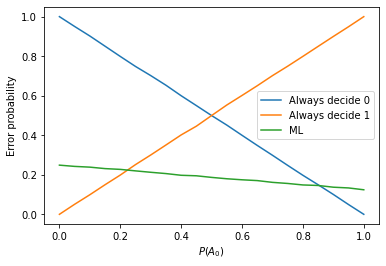

In [23]:
from tqdm import tqdm 
import matplotlib.pyplot as plt

input_probs = np.linspace(0,1,21)

pe_always0 = []
pe_always1 = []
pe_ML = []

for PA0 in tqdm(input_probs):
    pe_always0 += [sim2to3(always_decide0, P, PA0)]
    pe_always1 += [sim2to3(always_decide1, P, PA0)]
    pe_ML += [sim2to3(ML, P, PA0)]
    
plt.plot(input_probs, pe_always0, label='Always decide 0')
plt.plot(input_probs, pe_always1, label='Always decide 1')
plt.plot(input_probs, pe_ML, label='ML')
plt.xlabel(f'$P(A_0)$')
plt.ylabel('Error probability')
plt.legend();
    

From the figure, we can see that each of these three different decision rules minimize the probability of error over some specific range of $P(A_0)$. For low $P(A_0)$, it is best to always decide $A_1$. For medium $P(A_0)$ (in the range $0.2 < P(A_0) < 0.85$), it appears that it is best to apply the ML rule, and for larger $P(A_0)$, it is best to always decide $A_0$. And other decision rules are possible. We need a principled way to determine the optimum decision rule to minimize the error probability.

## Optimal Decisions to Minimize the Probability of Error: The MAP Rule

As before, let $\hat{A}_i$ denote the event that the decision is $i$. Then an error occurs if the decision is different than the actual input event. Let $E$ denote the error event, so

$$
E = \left(\hat{A}_0 \cap A_1\right) \cup \left(\hat{A}_1 \cap A_0\right).
$$

Note that $\left(\hat{A}_0 \cap A_1\right)$ and $\left(\hat{A}_1 \cap A_0\right)$ are mutually exclusive (since $A_0$ and $A_1$ are complementary events$. Thus 

$$
P(E) = P\left(\hat{A}_0 \cap A_1\right) + P \left(\hat{A}_1 \cap A_0\right).
$$


We can minimize the error probability if we minimize the error probability given the observation, $B_j$:

$$
P\left(E|B_j\right) = P\left(\hat{A}_0 \cap A_1 \left \vert B_j \right. \right) + P \left(\hat{A}_1 \cap A_0 \left \vert B_j \right. \right).
$$

In general, we can make a decision rule that is probabilistic, meaning that given $B_j$, we choose $\hat{A}_0$ with
some probability and $\hat{A}_1$ with some probability. However, that turns out to not be necessary: the optimum decision rule is deterministic. Thus, only one of the two terms in the summation will be retained; i.e., given $B_j$ only one of $\hat{A}_0$ and $\hat{A_1}$ will be occur. If given $B_j$, we always decide the most likely input was 0, then $\hat{A}_0$ occurs, and $P(E) = P\left(A_1 \left \vert B_j \right. \right)$; conversely, if given $B_j$, we always decide the most likely input was 1, then $\hat{A}_1$ occurs, and $P(E)=P \left( A_0 \left \vert B_j \right. \right).$

Since, we wish to minimize the $P(E)$, the decision rule given $B_j$ is received should be:
* $\hat{A}_0$ if $P\left(A_1 \left \vert B_j \right. \right) < P \left( A_0 \left \vert B_j \right. \right)$, and
* $\hat{A}_1$ if $P\left(A_1 \left \vert B_j \right. \right) > P \left( A_0 \left \vert B_j \right. \right)$, and
* either $\hat{A}_0$ or $\hat{A}_1$ if $P\left(A_1 \left \vert B_j \right. \right) = P \left( A_0 \left \vert B_j \right. \right)$.

```{note}

Although we didn't prove that the optimal decision rule is deterministic, it is not hard to see that any probabilistic decision rule would have an error probability that is  a linear combination of the probabilities $P\left(A_1 \left \vert B_j \right. \right)$ and  $P \left( A_0 \left \vert B_j \right. \right)$. The minimum value of a line on a closed interval is at one of the end points (i.e., one of the decisions has probability 1 and the other has probability 0), so the decision rule that minimizes the error probability is deterministic.
```

The decision rule that minimizes the error probability can be summarized as "choose the input that maximizes the *a posteriori* probability given the observation $B_j$. Mathematically, the minimum error probability rule is 

$$
\hat{A}_i \mbox{where} j = \arg \max_{i \in \{0,1\} } P \left( A_i \left \vert B_j \right. \right)
$$

Since we are choosing the input that maximizes the *a posteriori* probability (APP), we call this a *maximum a posteriori (MAP)* decision rule. We also use the following notation when the decision rule is between two possible inputs:

$$
P\left(A_0 \left \vert B_j \right. \right) 
\underset{1}{\overset{0}{\gtrless}}
 P \left( A_1 \left \vert B_j \right. \right).
 $$ (binary-map)

As in {doc}`bayes-rule`, the APPs are not given in the problem formulation, but we can find the APPs from the likelihoods and the *a priori* probabilities:

$$
P(A_i|B_j) = \frac{P(B_j|A_i)P(A_i)}{\sum_i P(B_j|A_i)P(A_i)}.
$$

If only the MAP decision is needed, then {eq}`binary-map` can be simplified:

\begin{align}
P\left(A_0 \left \vert B_j \right. \right)  & \underset{1}{\overset{0}{\gtrless}}  P \left( A_1 \left \vert B_j \right. \right)\\
\frac{P(B_j|A_0)P(A_0)}{\sum_i P(B_j|A_i)P(A_i)} & \underset{1}{\overset{0}{\gtrless}}
\frac{P(B_j|A_1)P(A_1)}{\sum_i P(B_j|A_i)P(A_i)} \\
{P(B_j|A_0)P(A_0)} & \underset{1}{\overset{0}{\gtrless}}
{P(B_j|A_1)P(A_1)}.
\end{align}

The APPs can be computed by implementing Bayes' rule in Python as follows for $P(A_0) = 1/5$ and $P(A_1)=4/5$:

In [20]:

aprioris = np.array([1/5,4/5])
for j in range(3):
    pBj=0
    for i in range(2):
        pBj+=P[i,j]*aprioris[i]
    print(f'P(B{j}) = {pBj}')
    for i in range(2):
        print(f'P(A{i}|B{j}) = {P[i,j]*aprioris[i]/pBj}')
    print()
        

P(B0) = 0.225
P(A0|B0) = 0.5555555555555556
P(A1|B0) = 0.4444444444444445

P(B1) = 0.15000000000000002
P(A0|B1) = 0.3333333333333333
P(A1|B1) = 0.6666666666666666

P(B2) = 0.6250000000000001
P(A0|B2) = 0.039999999999999994
P(A1|B2) = 0.96



The MAP rule for these *a priori* probabilities is **not any of the three rules previously introduced**! Let's create a MAP decision rule function:

In [21]:
def MAP(observation, P, PA0):
    # Take the $j$th colum and multiply it elementwise by the a priori probability vector
    scaled_apps = P[:,observation] * np.array([PA0, 1-PA0])
    return np.argmax(scaled_apps)

Let's now run a simulation comparing the performance of all of these decision rules:

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 21/21 [03:34<00:00, 10.20s/it]


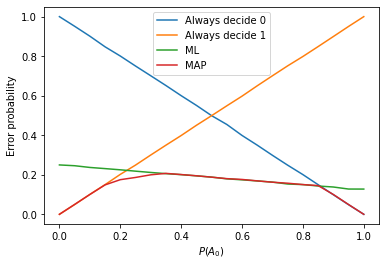

In [22]:
input_probs = np.linspace(0,1,21)

pe_always0 = []
pe_always1 = []
pe_ML = []
pe_MAP = []

for PA0 in tqdm(input_probs):
    pe_always0 += [sim2to3(always_decide0, P, PA0)]
    pe_always1 += [sim2to3(always_decide1, P, PA0)]
    pe_ML += [sim2to3(ML, P, PA0)]
    pe_MAP += [sim2to3(MAP, P, PA0)]
    
plt.plot(input_probs, pe_always0, label='Always decide 0')
plt.plot(input_probs, pe_always1, label='Always decide 1')
plt.plot(input_probs, pe_ML, label='ML')
plt.plot(input_probs, pe_MAP, label='MAP')
plt.xlabel(f'$P(A_0)$')
plt.ylabel('Error probability')
plt.legend();
    

As seen in the figure, the MAP rule achieves the lowest error probability for all values of $P(A_0)$. However, this does require the receiver to know the *a priori* values of the inputs.  If the *a priori* probabilities are note known, then the ML decision rule is usually used.

## Terminology Review

In [31]:
from jupytercards import display_flashcards

#display_flashcards('flashcards/'+'optimal-decisions.json')

github='https://raw.githubusercontent.com/jmshea/Foundations-of-Data-Science-with-Python/main/'
github+='07-bayesian-methods/flashcards/'
display_flashcards(github+'optimal-decisions.json')

